BERNARD Josephine

RECOUVREUX Gilles

-----------------
Compétition libre

# Setup

## Import libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
#        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import time

SEED = 420
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
!ls /kaggle/working

__notebook_source__.ipynb


## Load the images

In [4]:
gpu = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpu)

IMG_SHAPE = (80, 120, 3)

BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [5]:
working_dir = '/kaggle/input/navires-2023-libre/'
data_dir = working_dir + 'ships16x24/ships_16x24_10cat/data'

In [6]:
classes = os.listdir(data_dir)
print(classes)
num_classes = len(classes)
print(num_classes)

['methanier_scaled', 'corvette_scaled', 'containership_scaled', 'cruiser_scaled', 'cv_scaled', 'coastguard_scaled', 'destroyer_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']
10


# Data

## Analyse

class    coastguard_scaled
size                1827.0
dtype: object
class    tug_scaled
size         5454.0
dtype: object


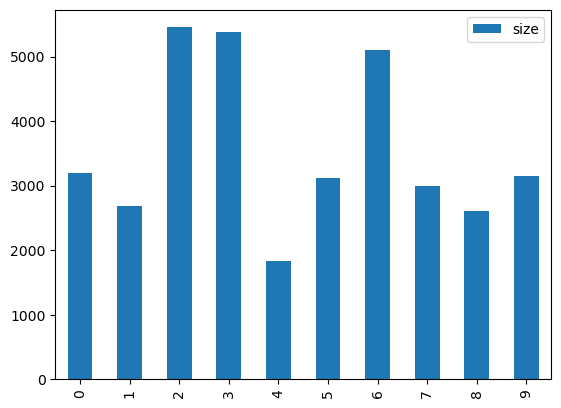

In [7]:
num_files = []
for classe in classes:
    num_files = np.append(num_files, len(os.listdir(os.path.join(data_dir, classe))))
    
df = pd.DataFrame()
df['class'] = classes
df['size'] = num_files
df.plot(kind='bar')

min_size = df.min()
print(min_size)
max_size = df.max()
print(max_size)

As we can see, the data is not homogenious, so we need to rebuilt it to have the same amount for each class, we do so because when we train with all the dataset, we have an overfitting.

## Class weights

We use class weights in order to train our model regardless the quantity of data of each class.

Because our dataset in not uniform we need to add more effect when we train on classes with less quantity.

In [8]:
total = df['size'].sum()
weights = (1 / df['size']) * (total / num_classes)
class_weight = weights.to_dict()

## Preprocess
We don't have a lot of data so we need to generate more data from the existing one.

In order to do that we will use data generator from ttendorflow.

In [9]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        brightness_range=(0.5,1.0),
        validation_split=0.1)

Now we can split our data in 2 sets:

- Training set (90%)
- Validation set (10%)

In [10]:
train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
        batch_size=BATCH_SIZE,
        seed=SEED,
        subset="training",
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
        batch_size=BATCH_SIZE,
        seed=SEED,
        subset="validation",
        class_mode='categorical')

Found 31968 images belonging to 10 classes.
Found 3547 images belonging to 10 classes.


Let's see our images.

In [11]:
def plot_generator(generator):

    labels = generator.class_indices
    plt.figure(figsize=(14,10))
  
    # Get images and labels from the next batch
    img, lbls = generator.next()
    print(f'Batch size: {img.shape[0]}\nImage size: {img.shape[1]} x {img.shape[2]}\nCanals number: {img.shape[3]}')

    for i in range(9):
        plt.subplot(3, 3, i + 1)
        num_class = np.where(lbls[i] == 1)[0][0]
        plt.title(list(labels.keys())[list(labels.values()).index(num_class)])
        plt.imshow(img[i])
    plt.show()

    generator.reset()

Batch size: 32
Image size: 80 x 120
Canals number: 3


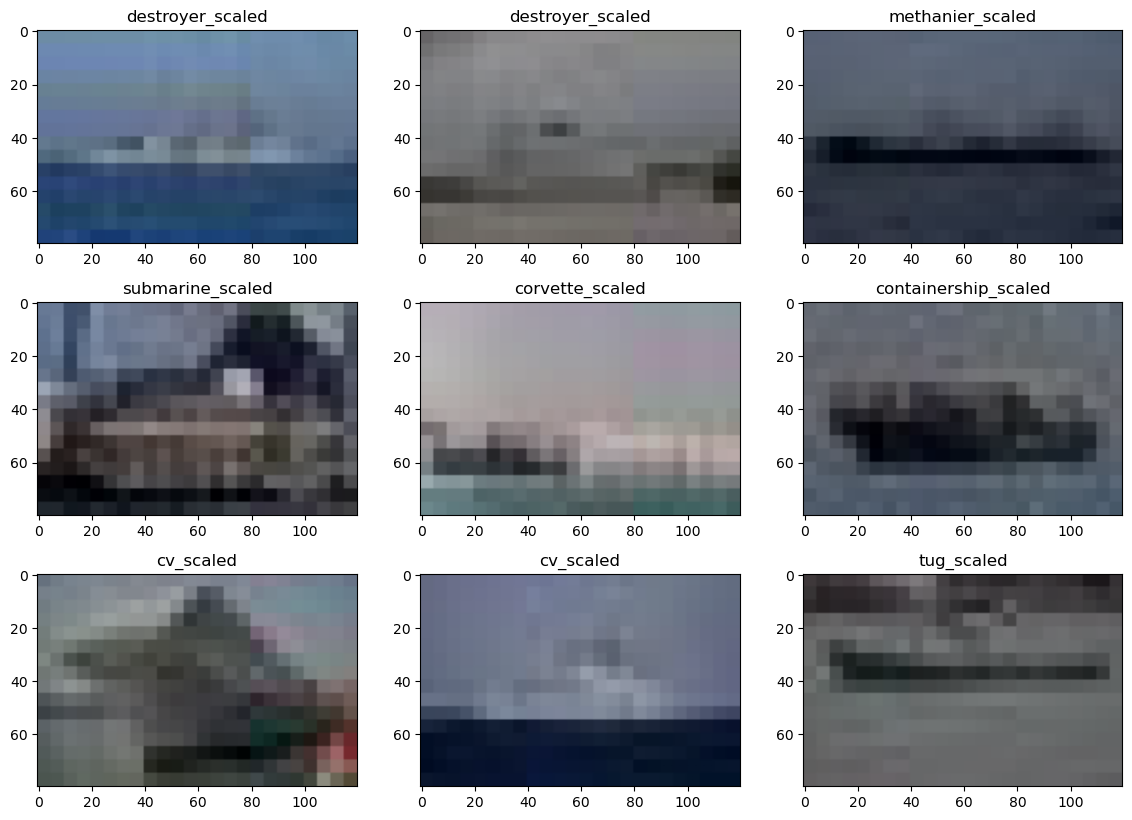

In [12]:
plot_generator(train_generator)

# Model
Now we will implement our neuronal network.

In [13]:
def plot_result():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

The pre-trained model is Xception

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.xception import Xception

def build_model():
    base_model = Xception(include_top=False, input_shape=IMG_SHAPE, weights="imagenet")

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(num_classes + 1, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Define the new model
    model = Model(base_model.input, output)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])

    return model

In [15]:
# buiding a model inside the strategy scope
with strategy.scope():
    model = build_model()

print("Nombre de couches : ", len(model.layers))
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Nombre de couches :  135
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 120, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 block1_conv1 (Conv2D)          (None, 39, 59, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 39, 59, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
    

In order to be sure our best model will be the one doing the prediuctions for the competitons, we use the callback ModelCheckpoint from tensorflow.

We also define a ReduceLROnPlateau in order to smoothly go to the best model when our loss is not improving.

We also define an EarlyStopping in order to prevent overfitting by stopping the training process early if the model's performance on a validation set doesn't improve.

In [16]:
best_model_path = '/kaggle/working/model/best'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience = 5)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [17]:
EPOCHS = 30

In [18]:
start_time_multi = time.time()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[
        model_checkpoint,
        reduce_lr,
        #callback
    ],
    #max_queue_size=100,
    #use_multiprocessing=True,
    workers=10,
    class_weight=class_weight,
    epochs=EPOCHS
)
final_time_multi = time.time() - start_time_multi
print("--- %s seconds ---" % (final_time_multi))

Epoch 1/30
999/999 [==============================] - 131s 94ms/step - loss: 1.5049 - accuracy: 0.5179 - val_loss: 1.2644 - val_accuracy: 0.5949 - lr: 0.0010
Epoch 2/30
999/999 [==============================] - 89s 88ms/step - loss: 1.0717 - accuracy: 0.6441 - val_loss: 0.9210 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 3/30
999/999 [==============================] - 88s 88ms/step - loss: 0.9123 - accuracy: 0.6959 - val_loss: 0.9326 - val_accuracy: 0.6910 - lr: 0.0010
Epoch 4/30
999/999 [==============================] - 89s 89ms/step - loss: 0.7951 - accuracy: 0.7369 - val_loss: 0.8462 - val_accuracy: 0.7226 - lr: 0.0010
Epoch 5/30
999/999 [==============================] - 87s 86ms/step - loss: 0.6963 - accuracy: 0.7655 - val_loss: 0.9818 - val_accuracy: 0.6992 - lr: 0.0010
Epoch 6/30
999/999 [==============================] - 92s 91ms/step - loss: 0.6204 - accuracy: 0.7892 - val_loss: 0.9502 - val_accuracy: 0.7048 - lr: 0.0010
Epoch 7/30
999/999 [==============================] - 87s

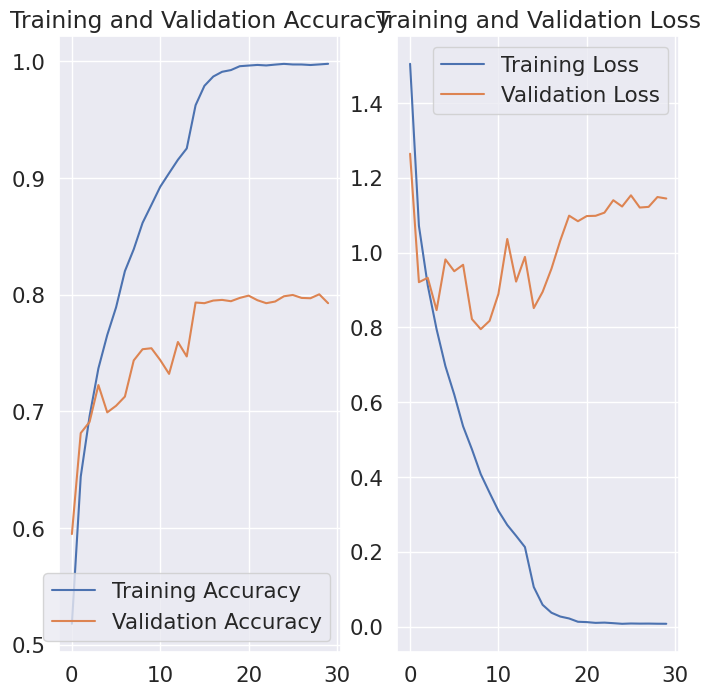

In [30]:
plot_result()

In [20]:
model.load_weights(best_model_path)

## Confusion Matrix
We print he confusion matrix of our model to see where our model need to be improved.

In [21]:
confusion_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SHAPE[0], IMG_SHAPE[1]),
    batch_size=BATCH_SIZE * 1000, # We multiply by 1000 in order to have only 1 line in the next cell
    seed=SEED,
    validation_split=0.1,
    subset='validation',
)
rescale_factor = 1.0 / 255.0 
rescaling_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=rescale_factor)
confusion_dataset = confusion_dataset.map(lambda x, y: (rescaling_layer(x), y))
confusion_dataset

Found 35515 files belonging to 10 classes.
Using 3551 files for validation.


<MapDataset element_spec=(TensorSpec(shape=(None, 80, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [22]:
pred = np.array([])
labels =  np.array([])
for x, y in confusion_dataset:
    pred = np.concatenate([pred, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, y.numpy()])

conf_mat = tf.math.confusion_matrix(labels=labels, predictions=pred).numpy()
conf_mat

111/111 [==============================] - 5s 23ms/step


array([[262,   1,  24,   6,   4,   5,   1,   3,   3,   2],
       [  0, 559,   1,   3,   1,   3,   0,   1,   1,   0],
       [  3,   0, 221,   0,   1,  25,   0,   0,   0,   1],
       [  1,   0,   0, 513,   0,   3,   0,   0,   0,   0],
       [  0,   0,   1,   2, 166,   2,   0,   0,   1,   0],
       [  0,   0,   3,   2,   3, 530,   0,   1,   0,   0],
       [  1,   4,   1,   1,   0,   0, 305,   0,   2,   0],
       [ 11,   2,   4,   2,   3,   5,   3, 264,   2,   1],
       [  0,   0,   3,   0,   1,   1,   0,   1, 267,   0],
       [  2,   0,   5,   0,   2,   8,   2,   1,   0, 288]], dtype=int32)

Text(0.5, 1.0, 'Confusion matrix')

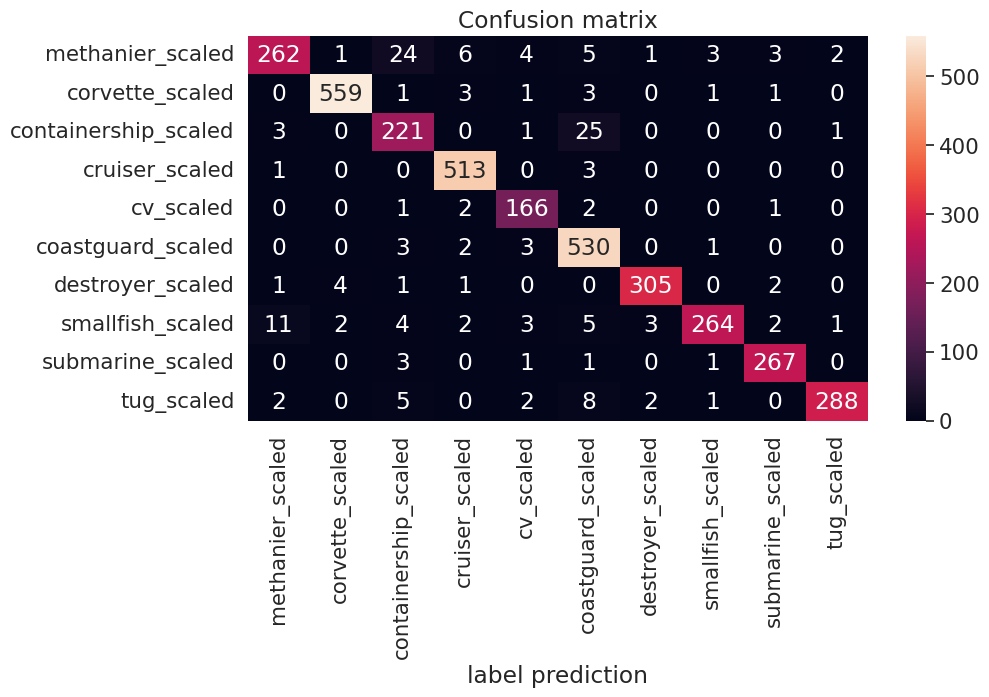

In [23]:
confusion_matrix_df = pd.DataFrame(conf_mat, classes, classes)
plt.figure(figsize=(10,5))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix_df, fmt='g', annot=True)
plt.xlabel('label prediction')
plt.title("Confusion matrix")

## Metrics
We print some important metrics of our model in order to have more information to help us to improve the model.

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

predictions_labels = pred
ground_truth = labels
accuracy = accuracy_score(ground_truth, predictions_labels)
precision = precision_score(ground_truth, predictions_labels, average='weighted')
recall = recall_score(ground_truth, predictions_labels, average='weighted')
f1 = f1_score(ground_truth, predictions_labels, average='weighted')
report = classification_report(ground_truth, predictions_labels, output_dict=True, digits=2)

Average Accuracy: 0.9504364967614757
Average Precision: 0.9515590829009977
Average Recall: 0.9504364967614757
Average F1: 0.9502626485791921


Text(0.5, 1.0, 'Report Matrix')

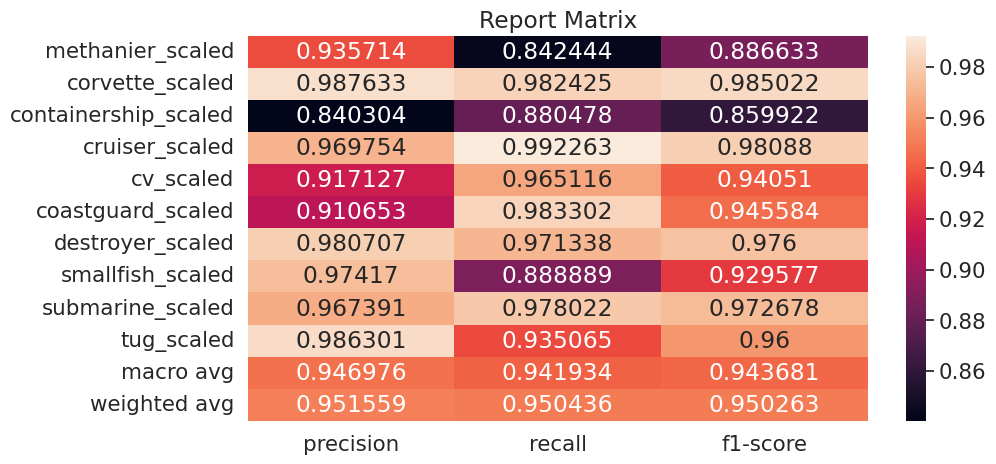

In [25]:
from functools import partial

print('Average Accuracy:', accuracy)
print('Average Precision:', precision)
print('Average Recall:', recall)
print('Average F1:', f1)

def getNameFromIndex(index):
    try:
        indexInt = int(float(index))
        return classes[indexInt]
    except ValueError:
        return index
report_df = pd.DataFrame.from_dict(report).drop(columns=['accuracy']).transpose().drop(columns=['support']).rename(mapper=partial(getNameFromIndex), axis='index')
plt.figure(figsize=(10,5))
sn.set(font_scale=1.4)
sn.heatmap(report_df, fmt='g', annot=True)
plt.title("Report Matrix")

# Submission

In [26]:
# Load test data
X_test = np.load(working_dir + 'test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

# Resize test data to match the expected input shape
X_test = tf.image.resize(X_test, (IMG_SHAPE[0], IMG_SHAPE[1]))

In [27]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("test.csv", index_label="Id")

116/116 [==============================] - 3s 23ms/step


In [28]:
!head test.csv

Id,Category
0,1
1,7
2,5
3,4
4,3
5,0
6,3
7,3
8,5


In [29]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'test.csv')

/kaggle/working/test.csv